In [3]:
import os, sys, requests, itertools
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

module_path = os.path.abspath(os.path.join('./utils'))
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)
    print(sys.path)
    
from utils import imdbUtils


/home/jade/repos/movie_recommender/utils
['/home/jade/repos/movie_recommender', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/jade/repos/movie_recommender/.recommender_system/lib/python3.8/site-packages', '/home/jade/repos/movie_recommender/utils']


In [19]:
#!python -m pip install requests
#!python -m pip install numpy
#!python -m pip install beautifulsoup4
#!python -m pip install pandas
#!python -m pip install -q transformers
#!python -m pip install tensorflow-gpu
#!python -m pip install torch
#!python -m pip install matplotlib

     |████████████████████████████████| 11.3 MB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 957 kB 7.6 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached Pillow-9.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [5]:
min_rating, max_rating = 4.0, 10.0
n_votes = 50000
genres = 'thriller'
title_count = 250

SEARCH_URL = f"https://www.imdb.com/search/title/?title_type=feature&user_rating={min_rating},{max_rating}&num_votes={n_votes},&genres={genres}&view=simple&sort=user_rating,desc&count={title_count}"

In [6]:
movies_soup = imdbUtils.getSoup(SEARCH_URL)

In [7]:
# find all a-tags with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))

print("There are a total of " + str(len(movie_tags)) + " movie titles")
print("Displaying 10 titles")
movie_tags[:10]

There are a total of 250 movie titles
Displaying 10 titles


['/title/tt0468569/',
 '/title/tt1375666/',
 '/title/tt0114369/',
 '/title/tt0102926/',
 '/title/tt6751668/',
 '/title/tt0482571/',
 '/title/tt0407887/',
 '/title/tt0114814/',
 '/title/tt0110413/',
 '/title/tt0054215/']

In [8]:
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]
print("There are a total of " + str(len(movie_links)) + " movie user reviews")
print("Displaying 10 user reviews links")
movie_links[:10]

There are a total of 250 movie user reviews
Displaying 10 user reviews links


['https://www.imdb.com/title/tt0468569/reviews',
 'https://www.imdb.com/title/tt1375666/reviews',
 'https://www.imdb.com/title/tt0114369/reviews',
 'https://www.imdb.com/title/tt0102926/reviews',
 'https://www.imdb.com/title/tt6751668/reviews',
 'https://www.imdb.com/title/tt0482571/reviews',
 'https://www.imdb.com/title/tt0407887/reviews',
 'https://www.imdb.com/title/tt0114814/reviews',
 'https://www.imdb.com/title/tt0110413/reviews',
 'https://www.imdb.com/title/tt0054215/reviews']

In [9]:
# get a list of soup objects
movie_soups = [imdbUtils.getSoup(link) for link in movie_links]

# get all 500 movie review links
movie_review_list = [imdbUtils.getReviews(movie_soup) for movie_soup in movie_soups]

movie_review_list = list(itertools.chain(*movie_review_list))
print(len(movie_review_list))

print("There are a total of " + str(len(movie_review_list)) + " individual movie reviews")
print("Displaying 10 reviews")
movie_review_list[:10]

500
There are a total of 500 individual movie reviews
Displaying 10 reviews


['https://www.imdb.com/review/rw1911671/',
 'https://www.imdb.com/review/rw5478826/',
 'https://www.imdb.com/review/rw2286063/',
 'https://www.imdb.com/review/rw4692192/',
 'https://www.imdb.com/review/rw3399062/',
 'https://www.imdb.com/review/rw2251710/',
 'https://www.imdb.com/review/rw0299417/',
 'https://www.imdb.com/review/rw1198894/',
 'https://www.imdb.com/review/rw5842146/',
 'https://www.imdb.com/review/rw4978432/']

In [10]:
# get review text from the review link
review_texts = [imdbUtils.getReviewText(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [imdbUtils.getMovieTitle(url) for url in movie_review_list]

In [11]:
# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list,
             'user_review': review_texts})

In [12]:
df.head()

,movie,user_review_permalink,user_review
0,The Dark Knight,https://www.imdb.com/review/rw1911671/,I thought Batman Begins was a very well concei...
1,The Dark Knight,https://www.imdb.com/review/rw5478826/,"Confidently directed, dark, brooding, and pack..."
2,Inception,https://www.imdb.com/review/rw2286063/,I have to say to make such an impressive trail...
3,Inception,https://www.imdb.com/review/rw4692192/,"My 3rd time watching this movie! Yet, it still..."
4,Seven,https://www.imdb.com/review/rw3399062/,"Bleak, gruesome, brilliant. These are a few of..."


In [13]:
df.to_csv('test_set.csv', index=False)

In [15]:
# Sentiment Analyser Model: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english?text=I+like+you.+I+love+you
## Not working in either Jupyter notebook or Visual Studio. See if we can find a fix. Works outside. Currently done in `main.py`.
## Maybe use it this way? !python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))" ## Approx 44s
!python main.py

2022-09-10 23:17:40.946795: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-10 23:17:41.011377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-10 23:17:41.011398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
trying sentiment analyser... 
             

In [16]:
df_withsent = pd.read_csv('data/test_set_withsent.csv')
df_withsent.head()

,movie,user_review_permalink,user_review,sentiment,sent_score
0,The Dark Knight,https://www.imdb.com/review/rw1917099/,"Dark, yes, complex, ambitious. Christopher Nol...",POSITIVE,0.999679
1,The Dark Knight,https://www.imdb.com/review/rw5478826/,"Confidently directed, dark, brooding, and pack...",POSITIVE,0.999876
2,Inception,https://www.imdb.com/review/rw2286063/,I have to say to make such an impressive trail...,NEGATIVE,0.994860
3,Inception,https://www.imdb.com/review/rw4692192/,"My 3rd time watching this movie! Yet, it still...",POSITIVE,0.999804
4,Seven,https://www.imdb.com/review/rw3399062/,"Bleak, gruesome, brilliant. These are a few of...",POSITIVE,0.994221


<AxesSubplot:>

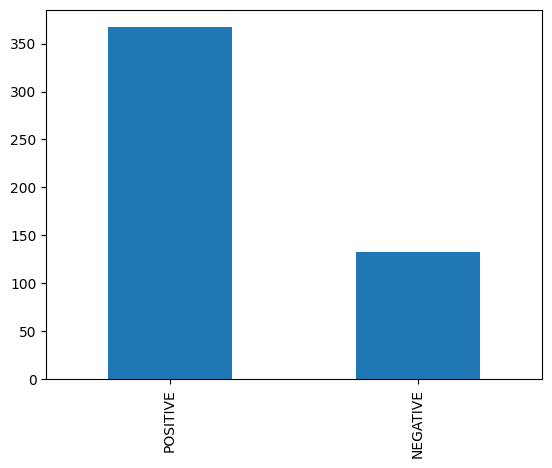

In [24]:
import matplotlib.pyplot as plt
df_withsent['sentiment'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

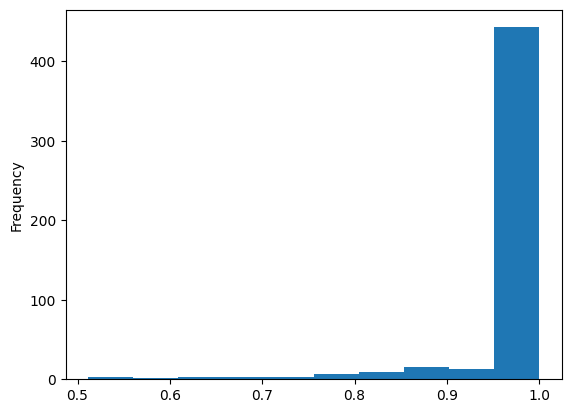

In [28]:
## Confident on most of the sentiments assigned but where are they less certain?
df_withsent['sent_score'].plot(kind='hist')

<AxesSubplot:>

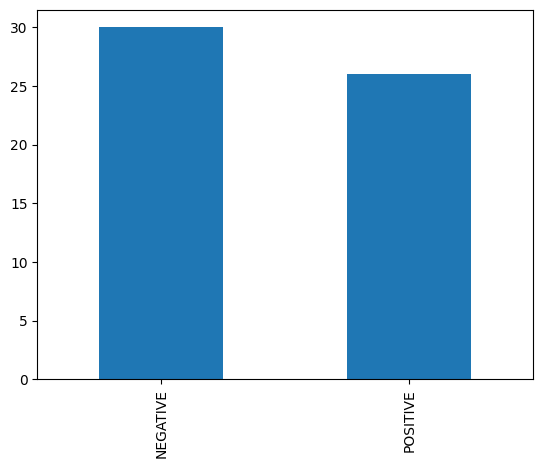

In [36]:
df_withsent[df_withsent['sent_score'] < 0.95]['sentiment'].value_counts().plot(kind='bar')